# 1.Introduction

The task is to provide insights to the building management about how to maintain the environmental guidance for an office environment. The data is provided in json packets.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import json

from tqdm import tqdm

## 2. Exploratory Data Analysis

Load the indoor and outdoor air quality data into dataframes first. From a quick glance the indoor air quality data is from various sensors. Instead of splitting this up into seperate dataframes, I can leave it in the same dataframe and just filter by the sensor id

The indoor air quality data will be the primary dataset, so lets do some EDA on it to see what we are working with.

### 2.1 Indoor air quality

In [32]:
#read in the json and encode the iso + zulu time information
iaq = pd.read_json("data/iaq.json", convert_dates=["documentTime"])
iaq.head()

,documentTime,temp,humidity,co2,sensor_id
0,2023-01-23 00:03:37+00:00,23.5,22,788,ENKZYW001792
1,2023-01-23 00:00:48+00:00,23.6,23,778,ENKZYW001804
2,2023-01-23 00:04:53+00:00,22.0,25,785,ENKZYW001882
3,2023-01-23 00:01:33+00:00,23.2,47,449,ENKZYW001856
4,2023-01-23 00:04:29+00:00,22.8,23,780,ENKZYW001848


In [33]:
print(f"{iaq.shape[0]} rows and {iaq.shape[1]} columns in the dataset")

102629 rows and 5 columns in the dataset


In [34]:
iaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102629 entries, 0 to 102628
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   documentTime  102629 non-null  datetime64[ns, UTC]
 1   temp          102629 non-null  float64            
 2   humidity      102629 non-null  int64              
 3   co2           102629 non-null  int64              
 4   sensor_id     102629 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


As expected, in this dataset we're working with ints and floats for the sensor readings, datettime for the read time and strings for the sensor id. It is also good that there is no missing data in this dataset, at least in the sense that no columns have any null values. 

**Assumption**: Nulls would only be present if the data recording mechanism fails, but if the sensor itself fails then the expected null values will be swapped out for another constant value. Given the time constraint, I am assuming that all sensors are working and none will reflect any systemic bias in the data.

Lets use the describe method to see the numerical attributes of the data



In [35]:
iaq.describe()

,temp,humidity,co2
count,102629.000000,102629.000000,102629.000000
mean,23.518861,31.273412,565.377155
std,1.151765,5.090771,150.045277
min,13.000000,20.000000,411.000000
25%,22.900000,28.000000,446.000000
50%,23.700000,30.000000,508.000000
75%,24.300000,34.000000,652.000000
max,27.200000,62.000000,1378.000000


The average values for all three features are within the operating goals of the building. At the extremes, humidity is still within the operating range, but the temperature and co2 measurements do spill out of the required boundries. The trends will be illuminated in the analysis section so lets not worry about it for now, but this data is useful in any EDA process.


I am now interested in seeing how many sensors we actually have. Do they all have the same amount of reads?

In [36]:
sensor_counts = iaq.sensor_id.value_counts()

print(f"There are {len(sensor_counts)} sensors in this dataset")
print(sensor_counts)

There are 14 sensors in this dataset
ENKZYW001883    7938
ENKZYW001884    7936
ENKZYW001900    7934
ENKZYW001848    7931
ENKZYW001819    7927
ENKZYW001792    7926
ENKZYW001958    7920
ENKZYW001888    7914
ENKZYW001837    7890
ENKZYW001925    7769
ENKZYW001882    7768
ENKZYW001804    7245
ENKZYW001856    4980
ENKZYW001935    3551
Name: sensor_id, dtype: int64


All sensors in this dataset have a different number of reads. No consequence of this for now, but good to keep in mind when it comes to critique the generated insights.


### 2.2 Sensor layout


To get some visual intuition, lets see if I can match the sensors to their location using the other data provided.

100%|██████████| 2/2 [00:00<00:00, 21.07it/s]


<Figure size 640x480 with 0 Axes>

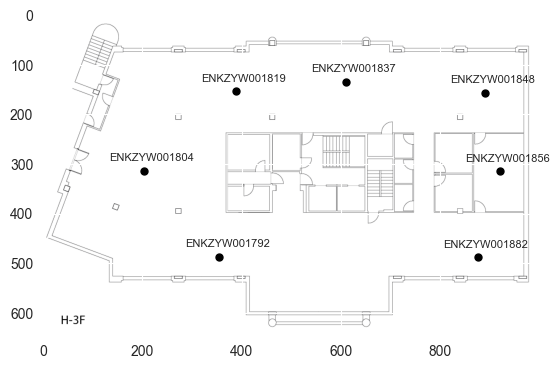

<Figure size 640x480 with 0 Axes>

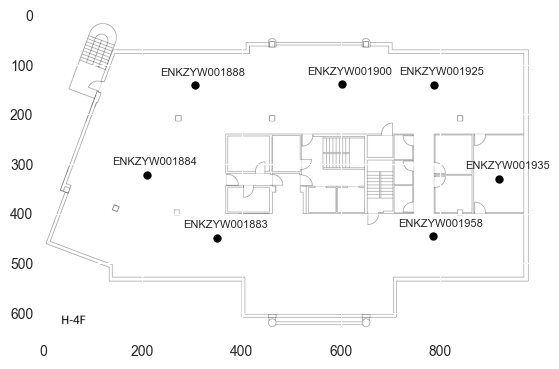

In [37]:
# This time lets read the json in as a dictionary
with open('data/floors.json') as json_file:
    floor_data = json.load(json_file)

#iterate and plot
for packet in tqdm(floor_data):
    
    image_name = packet["image"]["name"]

    #read the image into a enw figure
    plt.figure()
    im = plt.imread(f"data/{image_name}")
    fig, ax = plt.subplots()
    im = ax.imshow(im)

    #the sensors key is a list of more dictionarys
    sensors = packet["sensors"]

    #plot each sensor and annotate. At this point the coordinate system is the image standard i.e mirrored on the x axis
    for sensor in sensors:
        x,y = sensor["location"]["x"],sensor["location"]["y"]
        plt.plot(x,y,'k.',markersize=10)
        ax.annotate(sensor["sensor_id"], (x,y),xytext =(x - 70,y - 20), fontsize =8)

Interesting to see that the sensors are placed vaguely in the same spot on both floors. Also that the sensors are laid out in a ring-like structure. No apparant rhyme or reason to why some sensors have less readings than others though.

### 2.3 Outdoor air quality

In [38]:
#read in the json and encode the iso + zulu time information
oaq = pd.read_json("data/oaq.json", convert_dates=["documentTime"])
oaq.head()

,documentTime,temperature,humidity,windSpeed
0,2023-01-23 01:00:00+00:00,-1.3,89.5,NaN
1,2023-01-23 02:00:00+00:00,-1.5,90.0,NaN
2,2023-01-23 03:00:00+00:00,-1.8,90.0,NaN
3,2023-01-23 04:00:00+00:00,-2.2,90.7,NaN
4,2023-01-23 05:00:00+00:00,-2.3,91.0,NaN


In [39]:
print(f"{oaq.shape[0]} rows and {oaq.shape[1]} columns in the dataset")

2892 rows and 4 columns in the dataset


So the outdoor air quality data is far more limited than the indoor air quality. This is not unexpected, and was mentioned in the brief

In [40]:
oaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2892 entries, 0 to 2891
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   documentTime  2892 non-null   datetime64[ns, UTC]
 1   temperature   2892 non-null   float64            
 2   humidity      2892 non-null   float64            
 3   windSpeed     1814 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 90.5 KB


In [41]:
oaq.describe()

,temperature,humidity,windSpeed
count,2892.000000,2892.000000,1814.000000
mean,8.109336,82.011929,1.670838
std,2.944377,6.163737,1.335680
min,-2.700000,50.000000,0.100000
25%,6.200000,79.000000,0.800000
50%,8.300000,83.000000,0.800000
75%,10.500000,86.700000,2.775000
max,13.800000,93.000000,8.100000


37% of the windspeed data is null. Windspeed could cause significant impact to the humidity and co2 levels in the building by governing the rate of passive ventilation. I could either drop all indices where the windspeed is null, or impute the missing data. In the data processing section I will have to plot the windspeed and look for trends of seasonality to determine how to interpolate between missing data.

## 3. Data preperation

### 3.1 Windspeed

As determined in the previous section, a decision has to be made on what to do with missing values in the windspeed column of the outdoor air quality dataset. Lets plot it first and see what the seasonality or trend is.

In [42]:
oaq.head(3)

,documentTime,temperature,humidity,windSpeed
0,2023-01-23 01:00:00+00:00,-1.3,89.5,NaN
1,2023-01-23 02:00:00+00:00,-1.5,90.0,NaN
2,2023-01-23 03:00:00+00:00,-1.8,90.0,NaN


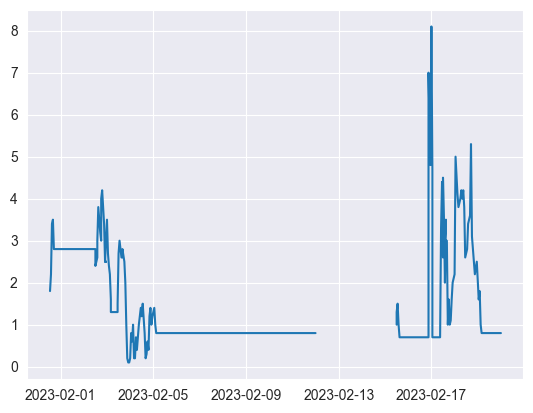

In [43]:
plt.plot(oaq.documentTime,oaq.windSpeed)

There are 2 groups of null values, one at the start and one in the middle. There seems to be no reas trend or seasonality in the data so we can impute the missing data but either interpolating, or doing something like a "carry last value" method. As wind speed is a pretty dynamic feature (it can change drastically between days) its is most representative to do a "carry last value forward" method to fill the data. With the initial null values, we could do a "carry next value back" method. With all that being said, the outdoor air quality data is already so limited compared to the indoor air quality that dropping a few days worth of data won't have much impact. Lets see how many days of data we would lose if we simply dropped the null rows.

In [49]:
oaq_missing_data = oaq[oaq.windSpeed.isna()].copy()
oaq_missing_data["date"] = oaq_missing_data.documentTime.dt.date

print(f"There are {len(oaq_missing_data.date.unique())} days worth of missing windspeed data")

There are 13 days worth of missing windspeed data


Ok so 13 days of missing data is actually quite a lot. Lets fill using a carry method.

In [54]:
#if we do a forward carry first, the initial null set will still be null. We can do a back fill on the resulting df
oaq = oaq.fillna(method="ffill").fillna(method="bfill")
oaq.head()

,documentTime,temperature,humidity,windSpeed
0,2023-01-23 01:00:00+00:00,-1.3,89.5,1.8
1,2023-01-23 02:00:00+00:00,-1.5,90.0,1.8
2,2023-01-23 03:00:00+00:00,-1.8,90.0,1.8
3,2023-01-23 04:00:00+00:00,-2.2,90.7,1.8
4,2023-01-23 05:00:00+00:00,-2.3,91.0,1.8
